In [11]:
import os
import math
import random
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
import librosa
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
NUM_LABELS = 10

def genOneHot(indexToBeOne):
    global NUM_LABELS
    oneHot = []
    for i in range(NUM_LABELS):
        if i == indexToBeOne:
            oneHot.append(1)
        else:
            oneHot.append(0)
    return np.array(oneHot)

def extractFeatures(raw, sr):
    mel = np.mean(librosa.feature.melspectrogram(raw, sr=sr).T,axis=0)
    return mel
    
def loadSoundFiles(filePath, index):
    IDEAL_SIZE = 22050
    NUM_SAMPLES = 1000
    oneHots = []
    soundFiles = os.listdir(filePath)
    features = np.empty((0, 144))
    
    counter = 0
    for soundFile in soundFiles:
        raw, sr = librosa.load(filePath + soundFile)
        if len(raw) == IDEAL_SIZE:
            mel = extractFeatures(raw, sr)
            mel = np.lib.pad(mel, (8,8), 'constant', constant_values=(0, 0))
            internalFeatures = np.hstack([mel])
            features = np.vstack([features, internalFeatures])
            counter += 1
            
            oneHot = genOneHot(index)
            if len(oneHots) == 0:
                oneHots = oneHot
            else:
                oneHots = np.vstack((oneHots, oneHot))
        
            if (counter % (NUM_SAMPLES / 10)) == 0:
                print(str((counter/NUM_SAMPLES) * 100) + "% complete")
        
            if counter == NUM_SAMPLES:
                break
            
    print("The one hot signature for this word is: " + str(oneHots[0]))
    print("The number of samples for this word is: " + str(len(features)))
        
    return np.array(features), oneHots
    
data = []
oneHots = []
rootDir = "./train/audio/"
acceptedWords = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
count = 1
for acceptedWord in acceptedWords:
    print(str(count) + "/" + str(NUM_LABELS))
    features, oneHot = loadSoundFiles(rootDir + acceptedWord + "/", count-1)
    data.append(features)
    oneHots.append(oneHot)
    count += 1
    
print("DONE")

1/10
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
The one hot signature for this word is: [1 0 0 0 0 0 0 0 0 0]
The number of samples for this word is: 1000
2/10
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
The one hot signature for this word is: [0 1 0 0 0 0 0 0 0 0]
The number of samples for this word is: 1000
3/10
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
The one hot signature for this word is: [0 0 1 0 0 0 0 0 0 0]
The number of samples for this word is: 1000
4/10
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
The one hot signature for this word is: [0 0 0 1 0 0 0 

In [4]:
dataTraining = []
trainingLabels = []
dataTest = []
testLabels = []

minSamples = 1000000
for training in data:
    if minSamples > len(training):
        minSamples = len(training)

numTrainingSamples = int(minSamples * 0.8)
numTestSamples = int(minSamples * 0.2)

for datasubset in data:
    if len(dataTraining) == 0:
        dataTraining = datasubset[:numTrainingSamples]
        dataTest = datasubset[numTrainingSamples:numTrainingSamples+numTestSamples]
    else:
        dataTraining = np.vstack((dataTraining, datasubset[:numTrainingSamples]))
        dataTest = np.vstack((dataTest, datasubset[numTrainingSamples:numTrainingSamples+numTestSamples]))
               
for oneHotInfo in oneHots:
    if len(trainingLabels) == 0:
        trainingLabels = oneHotInfo[:numTrainingSamples]
        testLabels = oneHotInfo[numTrainingSamples:numTrainingSamples+numTestSamples]
    else:
        trainingLabels = np.vstack((trainingLabels, oneHotInfo[:numTrainingSamples]))
        testLabels = np.vstack((testLabels, oneHotInfo[numTrainingSamples:numTrainingSamples+numTestSamples]))

print("Finished formatting the data to remove bias and to be ready for training")

Finished formatting the data to remove bias and to be ready for training


In [5]:
dataTraining, trainingLabels = shuffle(dataTraining, trainingLabels)
dataTest, testLabels = shuffle(dataTest, testLabels)
print("Randomized the order of the data and labels keeping the relationship 1 to 1")

Randomized the order of the data and labels keeping the relationship 1 to 1


In [6]:
def getBatch(data, labels, batchSize):
    randomIndexes = np.random.choice(len(data), batchSize)
    return data[randomIndexes], labels[randomIndexes]

In [9]:
tf.reset_default_graph()

NUM_SAMPLES = 144
NUM_CLASSIFICATIONS = NUM_LABELS
DENSE_LAYER = 256
RATE = 0.01
BATCH_SIZE = 100
EPOCHS = 5000
ITERATIONS_PER_EPOCH = 100

x = tf.placeholder(tf.float32, (None, NUM_SAMPLES))
ref = tf.placeholder(tf.float32, (None, NUM_CLASSIFICATIONS))
logits1 = tf.layers.dense(inputs=x, units=DENSE_LAYER, activation=tf.nn.relu, name="L1")
logits2 = tf.layers.dense(inputs=logits1, units=NUM_CLASSIFICATIONS, activation=None, name="L2")
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits2, labels=ref))

optimizer = tf.train.GradientDescentOptimizer(RATE).minimize(cost)
s = tf.Session()
s.run(tf.global_variables_initializer())

count = 0
trainingErrors = []
crossErrors = []
for _ in range(EPOCHS):
    inputData, correctAns = getBatch(dataTraining, trainingLabels, BATCH_SIZE)
    crossData, crossAns = getBatch(dataTraining, trainingLabels, BATCH_SIZE)
    for _ in range(ITERATIONS_PER_EPOCH):
        err, _ = s.run((cost, optimizer), feed_dict={x: inputData, ref: correctAns})
        crossErr = s.run((cost), feed_dict={x: crossData, ref: crossAns})
        trainingErrors.append(err)
        crossErrors.append(crossErr)
        count += 1
        if (count % ((EPOCHS * ITERATIONS_PER_EPOCH) / 100)) == 0:
            print(str(int(((count / (EPOCHS * ITERATIONS_PER_EPOCH)) * 100) + 0.5)) + "% complete: Training Error = " + str(err) + ". Cross Validation Error = " + str(crossErr))

1% complete: Training Error = 0.822656. Cross Validation Error = 11.4417
2% complete: Training Error = 0.748096. Cross Validation Error = 5.32659
3% complete: Training Error = 0.62498. Cross Validation Error = 3.87864
4% complete: Training Error = 0.615127. Cross Validation Error = 4.21392
5% complete: Training Error = 0.561508. Cross Validation Error = 5.94808
6% complete: Training Error = 0.581883. Cross Validation Error = 5.89089
7% complete: Training Error = 0.467992. Cross Validation Error = 8.03191
8% complete: Training Error = 0.459053. Cross Validation Error = 5.52584
9% complete: Training Error = 0.432372. Cross Validation Error = 6.33124
10% complete: Training Error = 0.286649. Cross Validation Error = 3.33333
11% complete: Training Error = 0.665954. Cross Validation Error = 3.49244
12% complete: Training Error = 0.375993. Cross Validation Error = 6.07497
13% complete: Training Error = 0.315573. Cross Validation Error = 4.47717
14% complete: Training Error = 0.456155. Cross V

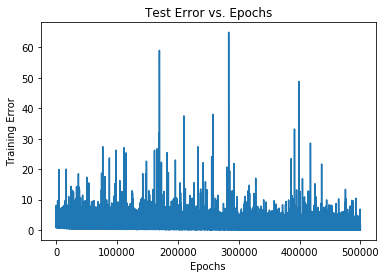

In [18]:
epochs = np.linspace(0, len(trainingErrors), len(trainingErrors))

plt.plot(epochs, trainingErrors)
plt.ylabel('Training Error')
plt.xlabel('Epochs')
plt.title('Test Error vs. Epochs')
plt.show()

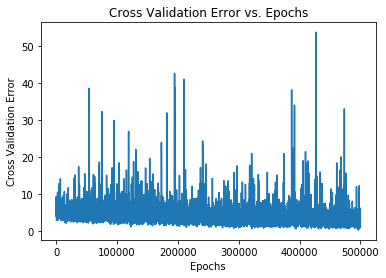

In [19]:
plt.plot(epochs, crossErrors)
plt.ylabel('Cross Validation Error')
plt.xlabel('Epochs')
plt.title('Cross Validation Error vs. Epochs')
plt.show()

In [20]:
probability = tf.nn.softmax(logits2)
prediction = tf.argmax((probability), axis=1)
guesses = s.run((prediction), feed_dict={x: dataTraining})

count = 0
corr = 0
categoriesRight = np.zeros(10)
for trainingLabel in trainingLabels:
    if (np.argmax(trainingLabel)) == guesses[count]:
        corr += 1
        categoriesRight[np.argmax(trainingLabel)] += 1
    count += 1

print("The mlp neural network is " + str((corr / len(guesses)) * 100) + "% accurate on the training data")
print(acceptedWords)
count = 0
print((categoriesRight / numTrainingSamples) * 100)

The mlp neural network is 76.1375% accurate on the training data
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
[ 92.375  82.5    83.     66.5    66.5    77.75   67.375  79.5    85.125
  60.75 ]


In [22]:
probability = tf.nn.softmax(logits2)
prediction = tf.argmax((probability), axis=1)
guesses = s.run((prediction), feed_dict={x: dataTest})

count = 0
corr = 0
categoriesRight = np.zeros(10)
for testLabel in testLabels:
    if (np.argmax(testLabel)) == guesses[count]:
        corr += 1
        categoriesRight[np.argmax(testLabel)] += 1
    count += 1
    
print("The mlp neural network is " + str((corr / len(guesses)) * 100) + "% accurate on the test data")
print(acceptedWords)
print((categoriesRight / numTestSamples) * 100)

The mlp neural network is 40.2% accurate on the test data
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
[ 66.   44.5  48.   26.   28.   28.   32.   48.   48.5  33. ]


In [23]:
cnnTraining = dataTraining
cnnTrainingLabels = trainingLabels
cnnTest = dataTest
cnnTestLabels = testLabels

def fixShape(data):
    return data.reshape(-1, 1, 144, 1)

In [24]:
tf.reset_default_graph()

NUM_SAMPLES = 144
DENSE_LAYER = 256
NUM_CLASSIFICATIONS = NUM_LABELS
RATE = 0.01
BATCH_SIZE = 100
EPOCHS = 5000
ITERATIONS_PER_EPOCH = 100
DROP_OUT_RATE = 0.5

class N():
    pass

model = N()

model.x = tf.placeholder(tf.float32, (None, 1, None, 1))
model.ref = tf.placeholder(tf.float32, (None, NUM_CLASSIFICATIONS))
model.drop = tf.placeholder(tf.float32)
model.L1 = tf.layers.conv2d(model.x, filters=32, kernel_size=(1,5), padding="SAME", activation=tf.nn.relu)
model.L2 = tf.layers.max_pooling2d(inputs=model.L1, pool_size=(1,2), strides=(1, 2))
model.L3 = tf.reshape(model.L2, (-1, 32*72))
model.L4 = tf.layers.dense(inputs=model.L3, units=DENSE_LAYER)
model.L5 = tf.nn.dropout(model.L4, model.drop)
model.L6 = tf.layers.dense(inputs=model.L5, units=NUM_CLASSIFICATIONS)
model.err = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.L6, labels=model.ref))

optimizer = tf.train.GradientDescentOptimizer(RATE).minimize(model.err)
s = tf.Session()
s.run(tf.global_variables_initializer())

count = 0
trainingErrors = []
crossErrors = []
for _ in range(EPOCHS):
    inputData, correctAns = getBatch(cnnTraining, cnnTrainingLabels, BATCH_SIZE)
    inputData = fixShape(inputData)
    crossData, crossAns = getBatch(cnnTraining, cnnTrainingLabels, BATCH_SIZE)
    crossData = fixShape(crossData)
    for _ in range(ITERATIONS_PER_EPOCH):
        err, _ = s.run((model.err, optimizer), feed_dict={model.x: inputData, model.ref: correctAns, model.drop: DROP_OUT_RATE})
        crossErr = s.run((model.err), feed_dict={model.x: crossData, model.ref: crossAns, model.drop: DROP_OUT_RATE})
        trainingErrors.append(err)
        crossErrors.append(crossErr)
        count += 1
        if (count % ((EPOCHS * ITERATIONS_PER_EPOCH) / 100)) == 0:
            print(str(int(((count / (EPOCHS * ITERATIONS_PER_EPOCH)) * 100) + 0.5)) + "% complete: Training Error = " + str(err) + ". Cross Validation Error = " + str(crossErr))

1% complete: Training Error = 1.1135. Cross Validation Error = 2.72626
2% complete: Training Error = 0.929001. Cross Validation Error = 3.02138
3% complete: Training Error = 0.945211. Cross Validation Error = 2.35194
4% complete: Training Error = 1.00073. Cross Validation Error = 1.84249
5% complete: Training Error = 1.08433. Cross Validation Error = 1.87194
6% complete: Training Error = 0.85115. Cross Validation Error = 1.91798
7% complete: Training Error = 0.937021. Cross Validation Error = 1.88359
8% complete: Training Error = 0.809352. Cross Validation Error = 2.011
9% complete: Training Error = 0.840017. Cross Validation Error = 2.17688
10% complete: Training Error = 0.921633. Cross Validation Error = 1.47759
11% complete: Training Error = 0.723239. Cross Validation Error = 1.34275
12% complete: Training Error = 0.649718. Cross Validation Error = 2.05595
13% complete: Training Error = 0.988082. Cross Validation Error = 1.40117
14% complete: Training Error = 0.949987. Cross Validat

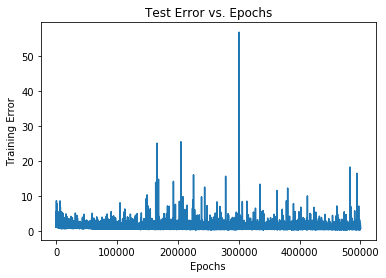

In [33]:
epochs = np.linspace(0, len(trainingErrors), len(trainingErrors))

plt.plot(epochs, trainingErrors)
plt.ylabel('Training Error')
plt.xlabel('Epochs')
plt.title('Test Error vs. Epochs')
plt.show()

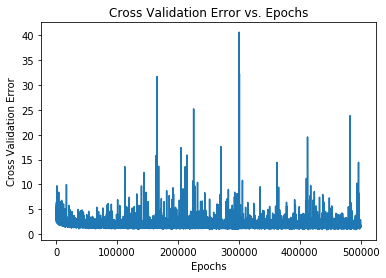

In [34]:
plt.plot(epochs, crossErrors)
plt.ylabel('Cross Validation Error')
plt.xlabel('Epochs')
plt.title('Cross Validation Error vs. Epochs')
plt.show()

In [30]:
probability = tf.nn.softmax(model.L6)
prediction = tf.argmax((probability), axis=1)
guesses = s.run((prediction), feed_dict={model.x: fixShape(cnnTraining), model.drop: DROP_OUT_RATE})

count = 0
corr = 0
categoriesRight = np.zeros(10)
for cnnTrainingLabel in cnnTrainingLabels:
    if (np.argmax(cnnTrainingLabel)) == guesses[count]:
        corr += 1
        categoriesRight[np.argmax(cnnTrainingLabel)] += 1
    count += 1

print("The cnn neural network is " + str((corr / len(guesses)) * 100) + "% accurate on the training data")
print(acceptedWords)
count = 0
print((categoriesRight / numTrainingSamples) * 100)

The cnn neural network is 52.81249999999999% accurate on the training data
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
[ 79.625  49.375  48.625  52.375  41.875  38.875  56.375  60.25   42.375
  58.375]


In [32]:
probability = tf.nn.softmax(model.L6)
prediction = tf.argmax((probability), axis=1)
guesses = s.run((prediction), feed_dict={model.x: fixShape(cnnTest), model.drop: DROP_OUT_RATE})

count = 0
corr = 0
categoriesRight = np.zeros(10)
for cnnTestLabel in cnnTestLabels:
    if (np.argmax(cnnTestLabel)) == guesses[count]:
        corr += 1
        categoriesRight[np.argmax(cnnTestLabel)] += 1
    count += 1
    
print("The cnn neural network is " + str((corr / len(guesses)) * 100) + "% accurate on the test data")
print(acceptedWords)
print((categoriesRight / numTestSamples) * 100)

The cnn neural network is 40.1% accurate on the test data
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
[ 61.5  29.5  40.5  39.   32.   29.   45.   46.5  34.   44. ]
